In [ ]:
A deep learning architecture of Hybrid Dilated Gated Separable Convolutional 
Neural Network (HDGS-Net) is designed，and constructed specifically for nucleosome 
occupancy prediction at single-base resolution.Using the HDGS-Net deep network, 
the nucleosome occupancy rate is regressed and predicted from the 16×146×1 sparse feature matrix,
completing the entire process of data loading → training → validation → testing → saving.

In [1]:
import h5py
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, 
Flatten,Dense, Lambda, Multiply, AveragePooling2D, Activation)
from tensorflow.keras.optimizers import Optimizer 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [2]:
def load_dense_data(file_path):
    with h5py.File(file_path, 'r') as f:
        indices = f['indices'][:]
        shape = tuple(f['shape'][:])
        label = f['label'][:]
    dense_matrix = np.zeros(shape, dtype=np.float32)
    for i, n, m in indices:
        dense_matrix[i, n, m] = 1
    return dense_matrix.reshape(*shape, 1), label

In [3]:
Nuar, label = load_dense_data('Training Feature Label Matrix/Training Matrix.h5')
print(Nuar.shape)
print(label.shape)

(3919, 16, 146, 1)
(3919,)


In [4]:
X_train,X_test,y_train,y_test=train_test_split(Nuar,label,test_size=0.2,random_state=1)
print(X_train.shape)
print(X_test.shape)

(3135, 16, 146, 1)
(784, 16, 146, 1)


In [5]:
save_dir = 'Convolutional Neural Network Model'
os.makedirs(save_dir, exist_ok=True)
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15),
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, 'Regression Model (no10).keras'), monitor='val_loss', save_best_only=True)]

In [6]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='valid',strides=(1,1),data_format='channels_last',
              dilation_rate=(1,1),activation='relu',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,data_format='channels_last',
               activation='relu',dilation_rate=dilation_rate,name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    return x

In [7]:
def Conv2d_NB(x, nb_filter,kernel_size, padding='valid',strides=(1,1),data_format='channels_last',
              dilation_rate=(1,1),activation='relu',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    x = BatchNormalization(name=bn_name)(x)
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,data_format='channels_last',
               activation='relu',dilation_rate=dilation_rate,name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    return x

In [8]:
def InceptionA(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_1x3_t = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Activation('sigmoid')(branch_1x3_s)
    branch_1x3_c = keras.layers.Multiply()([branch_1x3_t,branch_1x3_s])
       
    branch_1x7_t = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Activation('sigmoid')(branch_1x7_s)
    branch_1x7_c = keras.layers.Multiply()([branch_1x7_t,branch_1x7_s])
    
    branch_1x11_t = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',name=None)
    branch_1x11_s = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',name=None)
    branch_1x11_s = Activation('sigmoid')(branch_1x11_s)
    branch_1x11_c = keras.layers.Multiply()([branch_1x11_t,branch_1x11_s])
    
    branch_1x7_dt = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Activation('sigmoid')(branch_1x7_ds)
    branch_1x7_dc = keras.layers.Multiply()([branch_1x7_dt,branch_1x7_ds])
    
    branch_1x11_dt = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                               data_format='channels_last',activation='relu',
                               dilation_rate=(1,5),name=None)
    branch_1x11_ds = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                               data_format='channels_last',activation='relu',
                               dilation_rate=(1,5),name=None)
    branch_1x11_ds = Activation('sigmoid')(branch_1x11_ds)
    branch_1x11_dc = keras.layers.Multiply()([branch_1x11_dt,branch_1x11_ds])

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_1x3_c,branch_1x7_c,
                                          branch_1x7_dc,branch_1x11_dc]) 
    return x

In [9]:
def InceptionB(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_1x3_t = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Activation('sigmoid')(branch_1x3_s)
    branch_1x3_c = keras.layers.Multiply()([branch_1x3_t,branch_1x3_s])
       
    branch_1x7_t = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Activation('sigmoid')(branch_1x7_s)
    branch_1x7_c = keras.layers.Multiply()([branch_1x7_t,branch_1x7_s])
    
    branch_1x7_dt = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Activation('sigmoid')(branch_1x7_ds)
    branch_1x7_dc = keras.layers.Multiply()([branch_1x7_dt,branch_1x7_ds])

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_1x3_c,branch_1x7_c,branch_1x7_dc]) #

    return x

In [10]:
def InceptionC(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_1x3_t = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Activation('sigmoid')(branch_1x3_s)
    branch_1x3_c = keras.layers.Multiply()([branch_1x3_t,branch_1x3_s])
    
    branch_1x3_dt = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',
                              dilation_rate=(1,2),name=None)
    branch_1x3_ds = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',
                              dilation_rate=(1,2),name=None)
    branch_1x3_ds = Activation('sigmoid')(branch_1x3_ds)
    branch_1x3_dc = keras.layers.Multiply()([branch_1x3_dt,branch_1x3_ds])

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_1x3_c,branch_1x3_dc]) 
    return x

In [11]:
def TestNet(input_shape=None):
    inpt = Input(shape=input_shape)
    x = BatchNormalization()(inpt)
    x = InceptionA(x,64)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = InceptionA(x,128)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = InceptionB(x,128)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = InceptionC(x,64)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = Flatten(data_format='channels_last')(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(32,activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1,activation='relu')(x)
    model = Model(inpt,x,name='inception')
    return model

In [12]:
model = TestNet(input_shape=(16,146,1))
model.summary()

Model: "inception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 16, 146, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 16, 146, 1)        │               4 │ input_layer[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 146, 64)       │             128 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 146, 64)       │             256 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 16, 146, 64)       │             512 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 16, 146, 64)       │             512 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 16, 146, 64)       │             768 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 16, 146, 64)       │             128 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 16, 146, 64)       │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 146, 64)       │             256 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 16, 146, 64)       │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 16, 146, 64)       │             512 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 16, 146, 64)       │             256 │ conv2d_5[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 16, 146, 64)       │             512 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 16, 146, 64)       │             256 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 6,598,853 (25.17 MB)

 Trainable params: 6,592,195 (25.15 MB)

 Non-trainable params: 6,658 (26.01 KB)

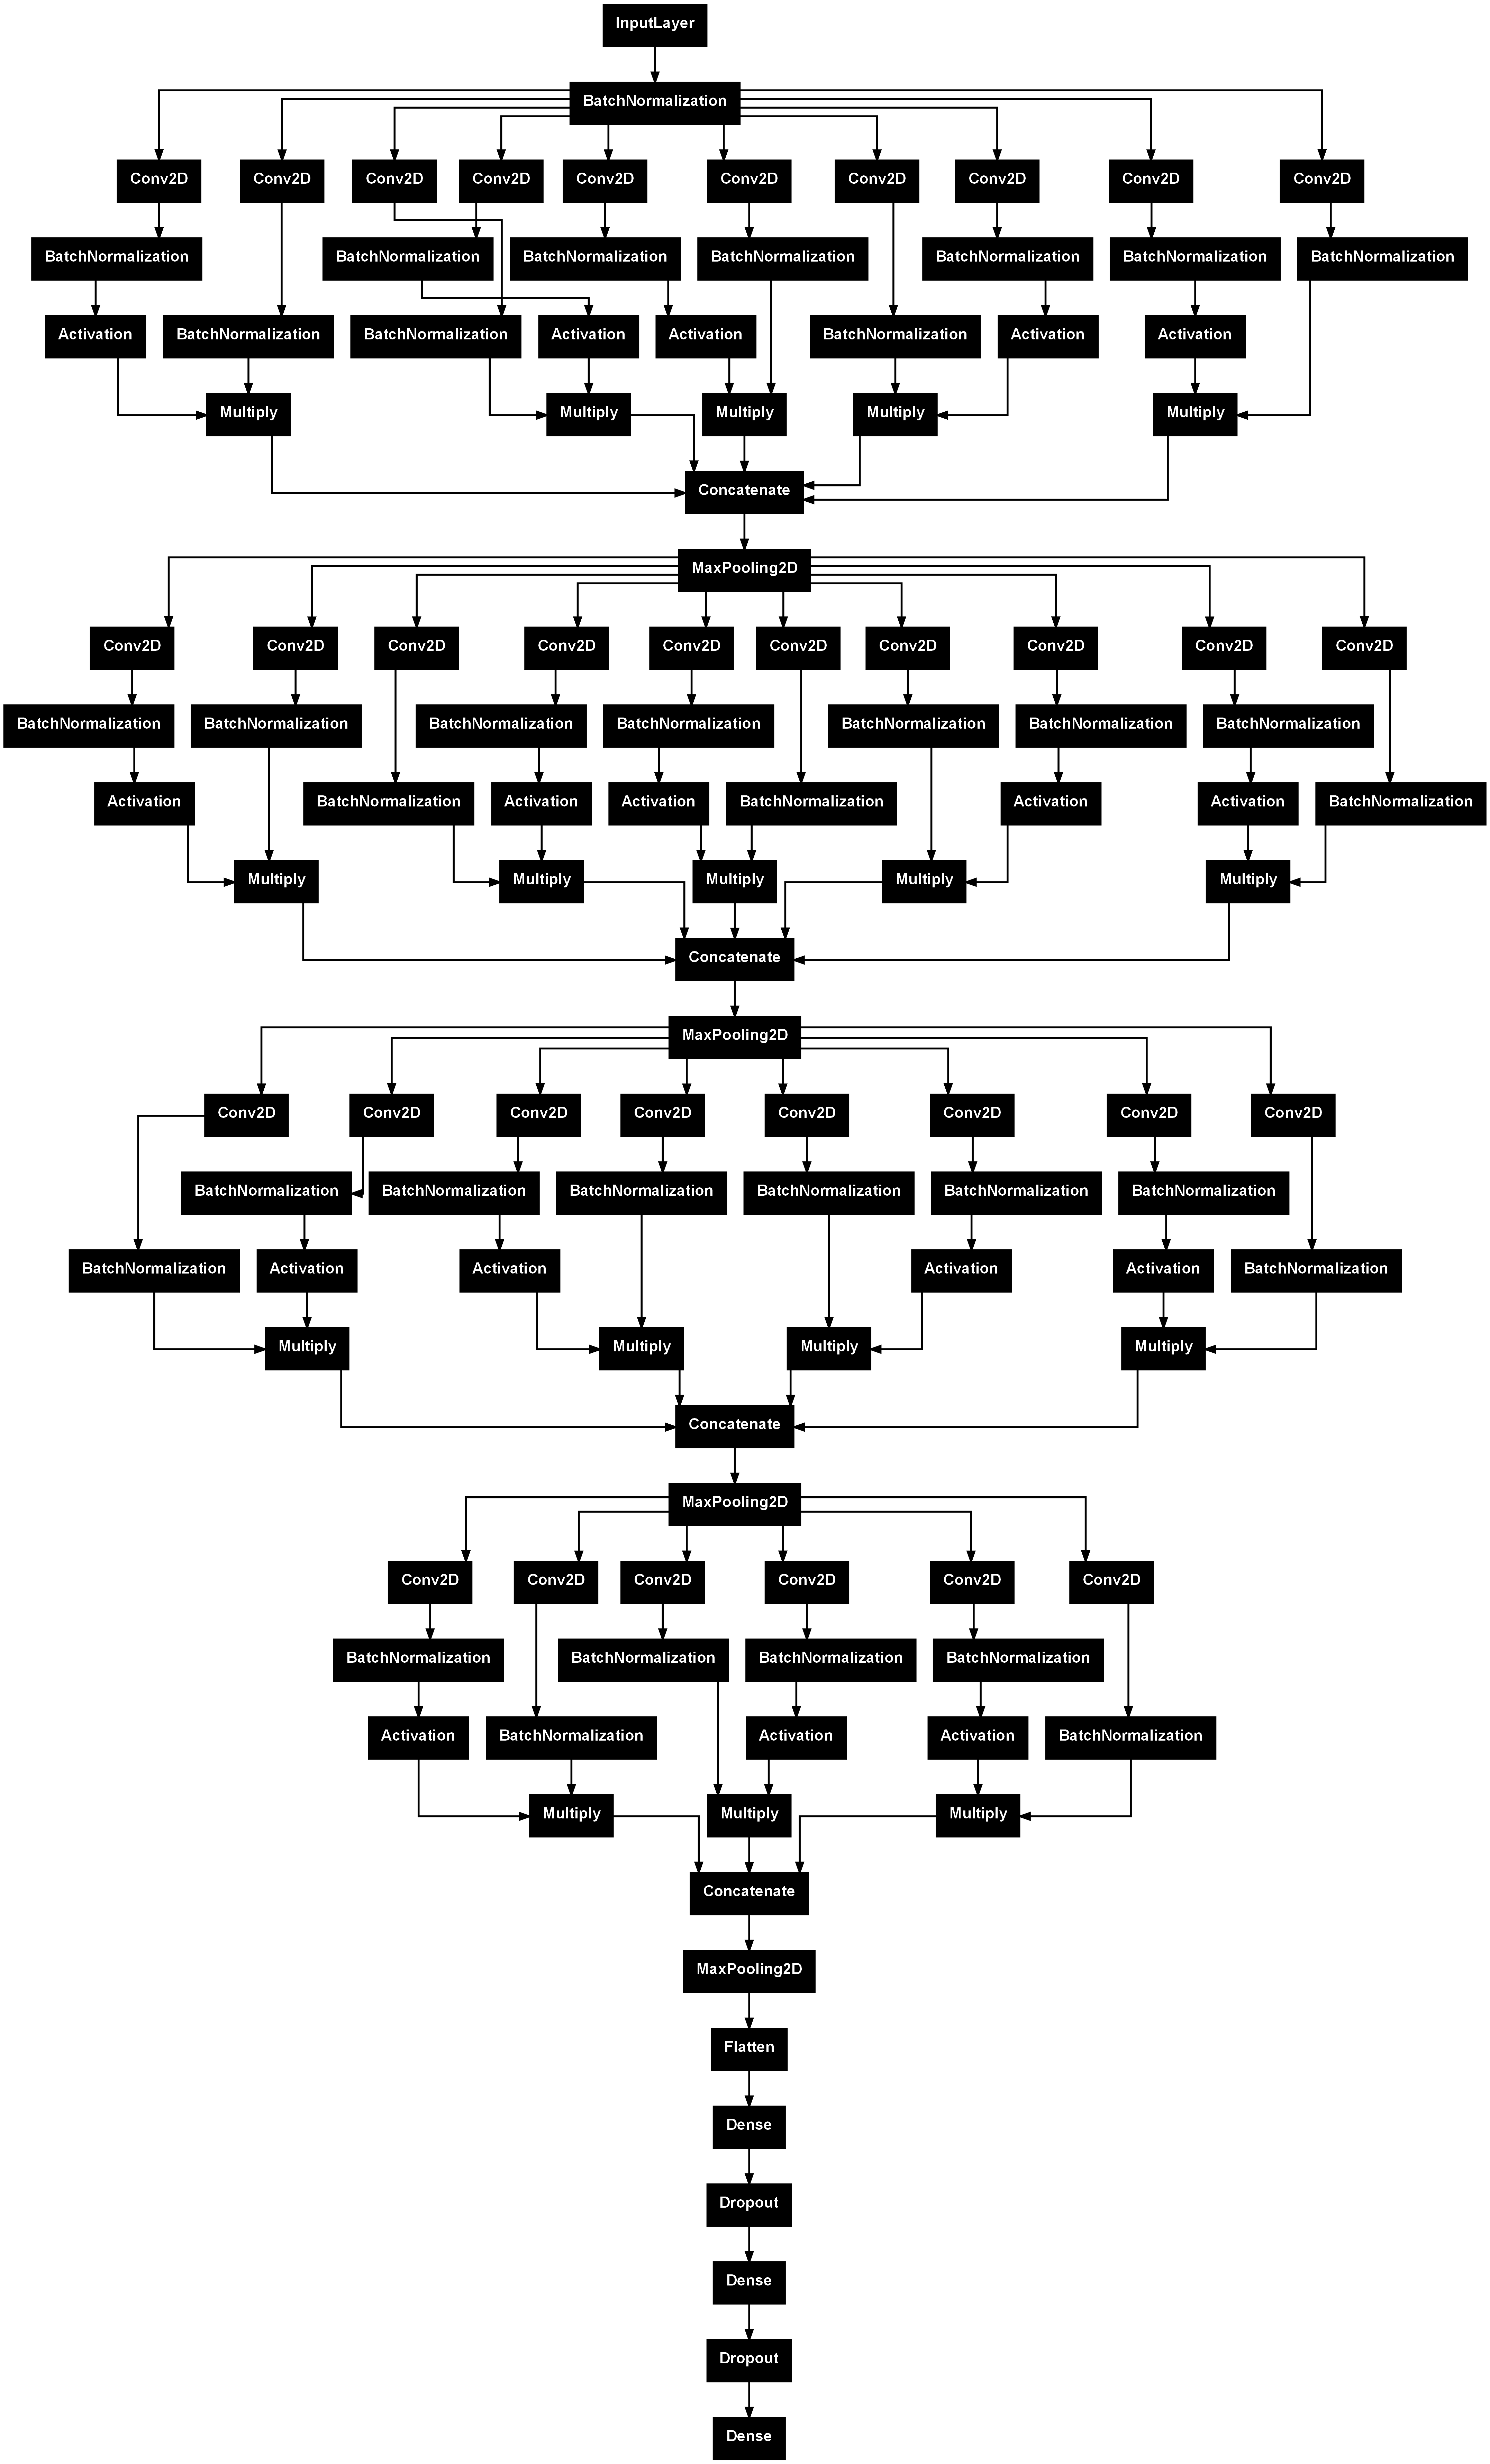

In [13]:
from tensorflow.keras.utils import plot_model    
plot_model(model,'Visualization Charts/Model structure diagram.png')

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
model.compile(loss='mse',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['mae'])

In [15]:
model.load_weights('Convolutional Neural Network Model/Regression weights (no10).h5')

In [16]:
model.fit(X_train,y_train,validation_split=0.25,epochs=20,batch_size=64,callbacks = callbacks_list)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 219s 6s/step - loss: 0.1393 - mae: 0.2853 - val_loss: 0.0959 - val_mae: 0.2250 - learning_rate: 1.0000e-04
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 220s 6s/step - loss: 0.1230 - mae: 0.2684 - val_loss: 0.0956 - val_mae: 0.2246 - learning_rate: 1.0000e-04
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - loss: 0.1234 - mae: 0.2672 - val_loss: 0.0955 - val_mae: 0.2248 - learning_rate: 1.0000e-04
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 219s 6s/step - loss: 0.1227 - mae: 0.2647 - val_loss: 0.0949 - val_mae: 0.2234 - learning_rate: 1.0000e-04
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 215s 6s/step - loss: 0.1217 - mae: 0.2695 - val_loss: 0.0945 - val_mae: 0.2226 - learning_rate: 1.0000e-04
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step - loss: 0.1160 - mae: 0.2551 - val_loss: 0.0942 - val_mae: 0.2217 - learning_rate: 1.0000e-04
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 221s 6s/step - loss: 0.1042 - mae: 0.2457 - val_loss: 0.0940 - val_mae: 0.2214 - learning_ra

In [17]:
test_loss,test_mae= model.evaluate(X_test,y_test)
print('test_mae:',test_mae)    

25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 677ms/step - loss: 0.0838 - mae: 0.2116
test_mae: 0.2157653123140335


In [18]:
from tensorflow.keras.models import load_model
model1 = load_model('Convolutional Neural Network Model/Regression Model (no10).keras')

In [19]:
test_loss,test_mae = model1.evaluate(X_test,y_test)
print('test_mae:',test_mae)

25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 514ms/step - loss: 0.0832 - mae: 0.2103
test_mae: 0.21432413160800934
